In [1]:
import numpy as np
from tqdm import tqdm
from scipy import signal
from pathlib import Path
from utils.plot_utils import *
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sympy import Symbol, zeros, Function, MatrixSymbol

Looking for a fast way to solve the following differential equation:

$\frac{𝜕𝜌}{𝑑𝑡}=−\frac{𝑖}{ℏ} [𝐻(𝑡),𝜌]+∑_k 𝐶_𝑘 𝜌𝐶_𝑘^\dagger-\frac{1}{2}∑_𝑘(𝐶_𝑘  𝐶_𝑘^\dagger 𝜌+𝜌𝐶_𝑘^\dagger 𝐶_𝑘 ) $

The results on an Intel i7 9700K overclocked to 4.3 GHz with 32 GB RAM are  

| method  | function call [ms] | ODE solve [s] | speedup |
| ------------- | ------------- | ------------- | ------------- |
| Matlab  |   | 1000 | 1 |
| Python naive  | 2.4 | 20 | |
| Python vectorized | 0.7 | 8 | 125 |
| Python vectorized + sparse | 0.14 | 1.6 | 625 | 
| Julia (single core) | 0.005 | 0.24 | 4167 |

Here function call denotes the time spend to calculate the RHS of the Lindblad equation.  
Note that all Matlab and the vectorized Python methods utilize BLAS and MKL to parallelize the matrix computations, utilizing multiple cores, whereas the Julia code ran on a single core.

## Defining some constants

These are used for setting up the OBE system for TlF

In [2]:
de_main = -0.39444661382277774 # main dipole transition moment

Γ = 1/(100e-9)
Ω =  4.5*Γ*de_main
ωp = Γ
νp = ωp/(2*np.pi)

# microwaves
Ω1 = 2*np.pi*1e6
νp1 = ωp/(2*np.pi)

# 'state' indices of the Hamiltonian arrays for the ground and excited state 
# respectively, which is the main state the laser couples
ground_main_idx = 26
excited_main_idx = 9

## Loading matrices used in OBE system

These matrices are for a 39x39 TlF system, $X,~J=0\rightarrow2;~B,~J=1$ with a laser on $X,~J=2 \rightarrow B,~J=1$  
The X is the ground state, B the excited state.  
`H_laser` are the lightfield Hamiltonians, here for x and z polarization.  
`C_array` contains the collapse operators $C_k$  
`ρ_ini` gives the initial distribution, in this case for TlF @7 K

In [3]:
data_dir = Path('stored_data')

fnames = ['H_laser_x', 'H_laser_z', 'H_X_red', 'H_B_red', 'H_B_diag', 'C_array', 'rho_ini', 'D1', 'H_mu1_y', 'H_mu1_z']

for fname in fnames:
    if fname == 'rho_ini':
        ρ_ini = np.load(data_dir / (fname + '.npy'))
    else:
        globals()[fname] = np.load(data_dir / (fname + '.npy'))
        
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

D1 = D1[:36,:36] # only include up to J=2
_ = np.zeros(H_laser_x.shape, dtype = 'complex')
_[:36,:36] = H_mu1_z[:36,:36]
H_mu1_z = _.copy()

_ = np.zeros(H_laser_x.shape, dtype = 'complex')
_[:36,:36] = H_mu1_y[:36,:36]
H_mu1_y = _.copy()

## Hamiltonian
### Time independent part

In [4]:
# shifting the X Hamiltonian such that the main ground level is set to zero
H_X_rot = H_X_red + D1
H_X_shifted = H_X_rot - H_X_rot[ground_main_idx,ground_main_idx]*np.eye(H_X_rot.shape[0])

# shifting the Y Hamiltonian such that the main excited level is set to zero
Δ = 0
H_B_shifted = np.diag(np.diag(H_B_red - H_B_diag[excited_main_idx,excited_main_idx] + Δ))

# creating a single array with both the X and B Hamiltonians
_H = np.zeros([39,39], dtype = 'complex')
_H[:36, :36] = H_X_shifted
_H[36:,36:] = H_B_shifted

### Time dependent part

In [5]:
# defining a square wave function, used for polarization switching

def square_wave(t, frequency, phase = 0):
    return 0.5*(1+signal.square(2*np.pi*frequency*t+phase))

In [6]:
# defining a function for the time dependent part of the Hamiltonian
H_oc_t = lambda t, Ω, νp: (Ω/de_main)/2*(H_laser_z*square_wave(t, νp, 0) + H_laser_x*square_wave(t, νp, np.pi))
H_mu1_t = lambda t, Ω, νp: Ω * (H_mu1_y * square_wave(t, νp, np.pi/2) + H_mu1_z * square_wave(t, νp, np.pi * 1.5))

# adding the time dependent and independent parts
def Hamiltonian(t, Ω, νp, Ω1, νp1):
    return _H + H_oc_t(t, Ω, νp) + H_mu1_t(t, Ω1, νp1)

## Setting up the Lindblad Equation
$\frac{𝜕𝜌}{𝑑𝑡}=−\frac{𝑖}{ℏ} [𝐻(𝑡),𝜌]+∑_k 𝐶_𝑘 𝜌𝐶_𝑘^\dagger-\frac{1}{2}∑_𝑘(𝐶_𝑘  𝐶_𝑘^\dagger 𝜌+𝜌𝐶_𝑘^\dagger 𝐶_𝑘 ) $  

Below calculate $L$ such that $∑_k 𝐶_𝑘 𝜌𝐶_𝑘^\dagger$ can be written as $L\cdot{\rm flat}(\rho)$ (courtesy of Oskari).

In [7]:
from scipy.sparse import kron, csr_matrix

L_collapse = np.zeros((C_array.shape[1]**2,C_array.shape[1]**2), dtype = complex)
identity = np.eye(C_array.shape[1],C_array.shape[2])
for C in tqdm(C_array):
    L_collapse += (kron(C.conj(), C)
                    -1/2 * (kron(identity, C.conj().T @ C) + 
                            kron(C.conj().T @ C, identity)))
    
# Make the collapse operator into a sparse matrix
L_collapse = csr_matrix(L_collapse)

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 72.69it/s]


In [8]:
# calculates the RHS of the Lindblad equation
# use numpy array operations as much as possible, this calls BLAS
# and numpy with MKL (Intel Math Kernel Library) this vectorizes
# common array operations over the CPU, using multiple cores

def Lindblad_rhs(t, rho_vec, p):
    Ω, νp, Ω1, νp1 = p
    dim = int(np.sqrt(len(rho_vec)))
    rho = rho_vec.reshape((dim,dim))
    
    Ham = Hamiltonian(t, Ω, νp, Ω1, νp1)

    rhs_H = (-1j* (Ham @ rho - rho @ Ham)).flatten()
    rhs_C = L_collapse @ rho_vec
    rhs = rhs_H + rhs_C
    return rhs

## Using Scipy to solve
With solve_ivp the default solver is `RK45`, but I explicitly call the method here for clarity.

In [9]:
t_span = (0, 100e-6)
ρ_vec = ρ_ini.flatten() # flatten the initial conditions, can't pass 2D array to the ODE solver
p = [Ω, νp, Ω1, νp1] # parameters to pass to function

In [10]:
%%timeit
# with MKL this utilizes multiple cores to do the array operations
# essentially splitting them over the cores
sol = solve_ivp(Lindblad_rhs, t_span, ρ_vec, method = 'RK45', dense_output=False, 
                vectorized = False, args = [p], rtol = 2.5e-4, atol = 2.5e-7)

7.1 s ± 383 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Wall time: 8.24 s


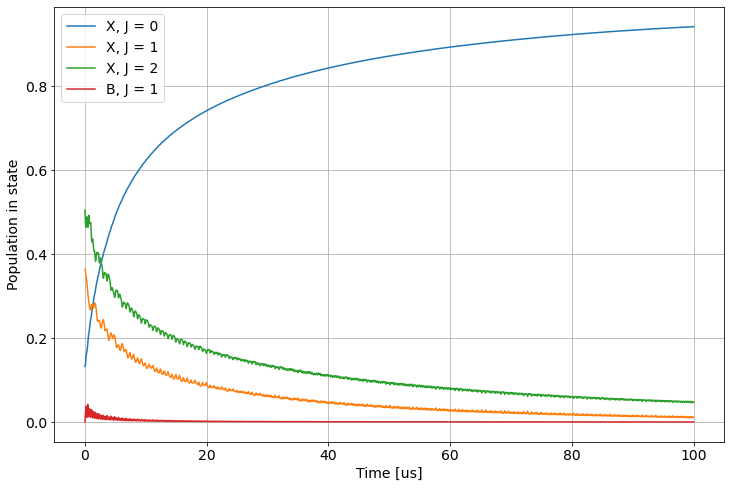

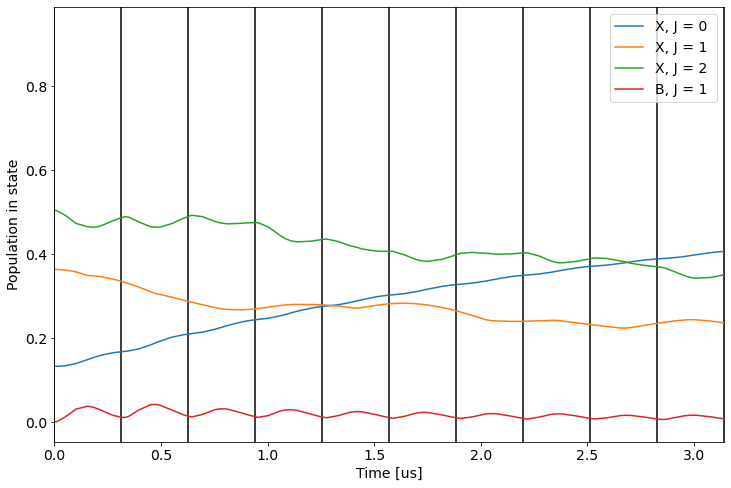

In [11]:
%%time
sol = solve_ivp(Lindblad_rhs, t_span, ρ_vec, method = 'RK45', dense_output=False, 
                vectorized = False, args = [p], rtol = 2.5e-4, atol = 2.5e-7)

pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((ρ_ini.shape[0], ρ_ini.shape[1], sol.y.shape[1]))))

t_array = sol.t

m = t_array <= 300e-6

t_array = t_array[m]
pop_results = pop_results[:,m]

#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1 ')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(0,5e6/νp)
for i in range(20):
    ax.axvline(i*1e6/νp/2, zorder = 0, color = 'k')

## Converting to symbolic for pre-calculation
Defining constants and functions as symbols

In [12]:
t = Symbol("t", real = True)
Ω = Symbol("Ω", complex = True)
Ωᶜ = Symbol("Ωᶜ", complex = True) # complex conjuage of Ω
Ω1 = Symbol("Ω1", complex = True)
Ω1ᶜ = Symbol("Ω1ᶜ", complex = True)
Δ = Symbol("Δ", real = True)

Plx = Function("Plx")(t) # Polarization switching function for laser x
Plz = Function("Plz")(t) # Polarization switching function for laser z

Pμ1y = Function("Pμ1y")(t) # Polarization switching function for microwave y
Pμ1z = Function("Pμ1z")(t) # Polarization switching function for microwave z

## Creating a symbolic density matrix
Used to do the symbolic matrix multiplication, so that we can auto-generate code that is essentially the operations of the RHS of the Lindblad equation written out line-by-line for each matrix element of the LHS.

In [13]:
def recursive_subscript(i):
    # chr(0x2080+i) is unicode for
    # subscript num(i), resulting in x₀₀ for example
    if i < 10:
        return chr(0x2080+i)
    else:
        return recursive_subscript(i//10)+chr(0x2080+i%10)

In [14]:
ρ = zeros(*ρ_ini.shape)
levels = ρ_ini.shape[0]
for i in range(levels):
    for j in range(i,levels):
        # \u03C1 is unicode for ρ, 
        if i == j:
            ρ[i,j] = Symbol(u'\u03C1{0},{1}'. \
            format(recursive_subscript(i), recursive_subscript(j)))
        else:
            ρ[i,j] = Symbol(u'\u03C1{0},{1}'. \
            format(recursive_subscript(i), recursive_subscript(j)))
            ρ[j,i] = Symbol(u'\u03C1{1},{0}'. \
            format(recursive_subscript(i), recursive_subscript(j)))

In [15]:
ρ[:4,:4]

Matrix([
[ρ₀,₀, ρ₀,₁, ρ₀,₂, ρ₀,₃],
[ρ₁,₀, ρ₁,₁, ρ₁,₂, ρ₁,₃],
[ρ₂,₀, ρ₂,₁, ρ₂,₂, ρ₂,₃],
[ρ₃,₀, ρ₃,₁, ρ₃,₂, ρ₃,₃]])

## Setting up the Hamiltonian with symbolic variables and functions

In [104]:
# setup the Hamiltonian, with time dependent functions for the laser polarization
Ham = zeros(*ρ_ini.shape)
Ham += ((Ω/de_main)/2)*(H_laser_z*Plz + H_laser_x*Plx) + Ω1*(H_mu1_y*Pμ1y + H_mu1_z*Pμ1z)
Ham += _H

In [105]:
# ensure Hermitian Hamiltonian for complex Ω
for idx in range(Ham.shape[0]):
    for idy in range(Ham.shape[0]):
        if idx > idy:
            Ham[idx,idy] = Ham[idx,idy].subs(Ω, Ωᶜ)
            Ham[idx,idy] = Ham[idx,idy].subs(Ω1, Ω1ᶜ)

In [106]:
# add a detuning to the excited state
for i in range(36,39):
    Ham[i,i] += Δ

### Doing the matrix calculations
Pretty slow because of the use of symbolic matrices, but in principle only necessary once.  
First part calculates $∑_k 𝐶_𝑘 𝜌𝐶_𝑘^\dagger$

In [107]:
matrix_mult_sum = zeros(39,39)
for idx in tqdm(range(C_array.shape[0])):
    matrix_mult_sum[:,:] += C_array[idx]@ρ@C_conj_array[idx]

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [04:42<00:00,  8.57s/it]


calculating $[𝐻(𝑡),𝜌]$ and $\frac{1}{2}∑_𝑘(𝐶_𝑘  𝐶_𝑘^\dagger 𝜌+𝜌𝐶_𝑘^\dagger 𝐶_𝑘 ) $

In [108]:
Cprecalc = np.einsum('ijk,ikl', C_conj_array, C_array)
a = -0.5 * (Cprecalc@ρ + ρ@Cprecalc)
b = -1j*(Ham@ρ - ρ@Ham)

Adding them all up to get $−\frac{𝑖}{ℏ} [𝐻(𝑡),𝜌]+∑_k 𝐶_𝑘 𝜌𝐶_𝑘^\dagger-\frac{1}{2}∑_𝑘(𝐶_𝑘  𝐶_𝑘^\dagger 𝜌+𝜌𝐶_𝑘^\dagger 𝐶_𝑘 ) $

In [109]:
res = zeros(*ρ_ini.shape)
res += matrix_mult_sum
res += b
res += a

In [110]:
res[0,0]

3367347.38920463*ρ₃₆,₃₆ + 3367525.85757619*ρ₃₇,₃₇ + 3367704.32982946*ρ₃₈,₃₈

In [111]:
res[-1,-1]

-9999999.99153049*ρ₃₈,₃₈ - 1.0*I*(3571166.10795539*ρ₁₇,₃₈*Plx(t) - 5050354.35386016*ρ₁₈,₃₈*Plz(t) + 813561.255214661*ρ₂₁,₃₈*Plx(t) - 1992585.85654462*ρ₂₂,₃₈*Plz(t) - 1992363.21643682*ρ₂₃,₃₈*Plx(t) + 3138158.93766183*ρ₂₆,₃₈*Plx(t) - 7686031.14738699*ρ₂₇,₃₈*Plz(t) - 7685875.25104091*ρ₂₈,₃₈*Plx(t) - 3571166.10795539*ρ₃₈,₁₇*Plx(t) + 5050354.35386016*ρ₃₈,₁₈*Plz(t) - 813561.255214661*ρ₃₈,₂₁*Plx(t) + 1992585.85654462*ρ₃₈,₂₂*Plz(t) + 1992363.21643682*ρ₃₈,₂₃*Plx(t) - 3138158.93766183*ρ₃₈,₂₆*Plx(t) + 7686031.14738699*ρ₃₈,₂₇*Plz(t) + 7685875.25104091*ρ₃₈,₂₈*Plx(t))

## Convert matrix to system of equations code
Calculating the LHS of the Lindblad equation results in a 2D array, and here we go through the array element by element and write them out as single lines of code, i.e.:
```Julia
du[1,1] = 3367347.38920463*ρ[37,37] + 3367525.85757619*ρ[38,38] + 3367704.32982946*ρ[39,39]
```
Note that Julia arrays start at 1, whereas python starts at 0.

In [112]:
code_lines = []
for idx in tqdm(range(res.shape[0])):
    for idy in range(res.shape[0]):
        if res[idx,idy] != 0:
            cline = str(res[idx,idy])
            cline = f"du[{idx+1},{idy+1}] = " + cline
            cline = cline.replace("Plx(t)", "Plx")
            cline = cline.replace("Plz(t)", "Plz")
            cline = cline.replace("Pμ1y(t)", "Pm1y")
            cline = cline.replace("Pμ1z(t)", "Pm1z")
            cline = cline.replace("I", "1im")
            cline += '\n'
            for i in range(res.shape[0]):
                for j in range(res.shape[1]):
                    _ = str(ρ[i,j])
                    cline = cline.replace(_+"*", f"ρ[{i+1},{j+1}]*")
                    cline = cline.replace(_+" ", f"ρ[{i+1},{j+1}] ")
                    cline = cline.replace(_+"\n", f"ρ[{i+1},{j+1}]")
                    cline = cline.replace(_+")", f"ρ[{i+1},{j+1}])")
            cline = cline.strip()
            code_lines.append(cline)

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:34<00:00,  1.14it/s]


In [113]:
code_lines[:4]

['du[1,1] = 3367347.38920463*ρ[37,37] + 3367525.85757619*ρ[38,38] + 3367704.32982946*ρ[39,39]',
 'du[1,2] = -83545.9813842773*1im*ρ[1,2]',
 'du[1,3] = -83566.3651275635*1im*ρ[1,3]',
 'du[1,4] = -83586.7483215332*1im*ρ[1,4]']

# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [Waveforms](https://github.com/Paalon/Waveforms.jl) $\rightarrow$ used for a square wave function
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [BenchmarkTools](https://github.com/JuliaCI/BenchmarkTools.jl)  

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [114]:
from julia import Main

In [115]:
Main.eval("""using Waveforms""")
Main.eval("""using DifferentialEquations""")
Main.eval("""using BenchmarkTools""")

## Define Square Wave in Jullia

In [116]:
Main.eval("""
function square_wave(t::Float64, frequency::Float64, phase::Float64)
    0.5.*(1 .+ squarewave(2*pi.*frequency.*t .+ phase))
end
""")

<PyCall.jlwrap square_wave>

## Creating the Julia function to compute the RHS of the Lindblad Equation
Note that only here the polarization switching function is added.  
Anything added symbolically can be modified here.

In [117]:
ode_fun = """
function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩ = p[1]
\t\tΩᶜ = conj(Ω)
\t\tνp = p[2]
\t\tΩ1 = p[3]
\t\tΩ1ᶜ = conj(Ω1)
\t\tνp1 = p[4]
\t\tΔ = p[5]
\t\tPlx = square_wave(t, νp, 3.141592653589793)
\t\tPlz = square_wave(t, νp, 0.0)    
\t\tPm1y = square_wave(t, νp1, 1.5707963267948966)
\t\tPm1z = square_wave(t, νp1, 4.71238898038469)
"""

In [118]:
print(ode_fun)


function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ω = p[1]
		Ωᶜ = conj(Ω)
		νp = p[2]
		Ω1 = p[3]
		Ω1ᶜ = conj(Ω1)
		νp1 = p[4]
		Δ = p[5]
		Plx = square_wave(t, νp, 3.141592653589793)
		Plz = square_wave(t, νp, 0.0)    
		Pm1y = square_wave(t, νp1, 1.5707963267948966)
		Pm1z = square_wave(t, νp1, 4.71238898038469)



In [119]:
for cline in code_lines:
    ode_fun += "\t\t"+cline+'\n'
ode_fun += '\t end \n \t nothing \n end'

In [120]:
with open('ode_fun_mu1.jl', 'w', encoding='utf8') as f:
    f.write(ode_fun)

In [121]:
# reading from file
with open('ode_fun_mu1.jl', 'r', encoding='utf8') as f:
    ode_fun = f.read()

This creates a Julia function

In [122]:
# making the function in Julia
Main.eval(ode_fun)

<PyCall.jlwrap Lindblad_rhs!>

Setup the variables needed in Julia by sending them from python to Julia

In [123]:
Γ = 1/(100e-9)
Ω =  4.5*Γ*abs(de_main)
ωp = Γ
νp = ωp/(2*np.pi)
νp1 = νp
Ω1 = 2*np.pi * 1e6 
Δ = 0

Main.Ω = Ω
Main.νp = νp
Main.Ω1 = Ω1
Main.νp1 = νp1
Main.Δ = Δ
Main.Γ = Γ

Main.ρ_ini = ρ_ini

# setting up the parameters to send to the differential equation
Main.eval("p = [Ω, νp, Ω1, νp1, Δ]")

array([17750097.622025  ,  1591549.43091895,  6283185.30717959,
        1591549.43091895,        0.        ])

In [124]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
@time Lindblad_rhs!(du, ρ_ini, [Ω, νp, Ω1, νp1, Δ], 0.)
tmp = 0
""")

Wall time: 56.8 s


0

In [125]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
@time Lindblad_rhs!(du, ρ_ini, [Ω, νp, Ω1, νp1, Δ], 0.)
tmp = 0
""")

Wall time: 65.9 ms


0

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [126]:
Main.eval("""
tspan = (0.0f0, 100e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

0

The ODEProblem is then solved with the `solve` function, which takes as inputs the ODEProblem `prob`, the method (`Tsit5()` in this case, a RK45 like method), tolerances and many more parameters (more detail [here](https://diffeq.sciml.ai/stable/basics/common_solver_opts/)).  
Julia has a JIT compiler, so the first run compiles the code, which means it takes a bit longer. Any subsequent runs (even with changing parameters) will run much faster, provided the type of the parameters doesn't change. Changing the type changes the function signature and requires recompilation.

In [127]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 2.5e-7, reltol = 2.4e-4)
tmp = 0
""")

Wall time: 8.54 s


0

@time prints the actual runtime in Julia into the terminal (8.54 s)
### Second run; code already compiled

In [129]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 2.5e-7, reltol = 2.4e-4)
tmp = 0
""")

Wall time: 992 ms


0

after compilation it runs in 992 ms. This may not seem that much faster than python (7.1 vs 992 ms), but remember that whereas python uses multiple cores for array operations, this only uses a single core. We can get another massive speedup by utilizing multiple cores for solving the same system for different initial conditions or parameters.

7.093809021313151


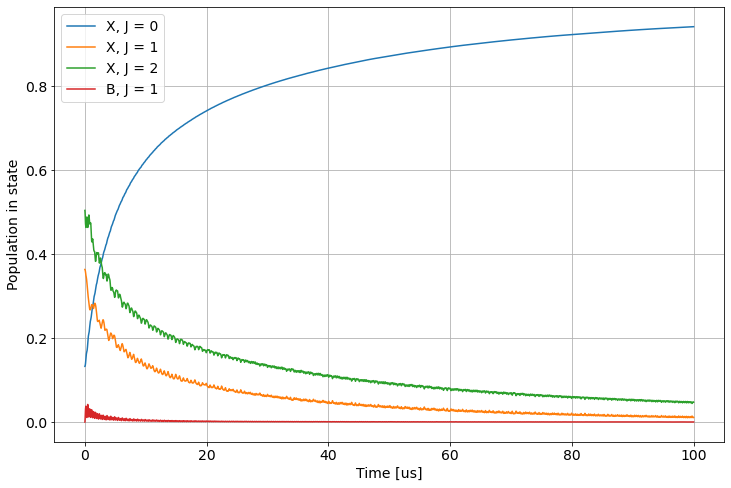

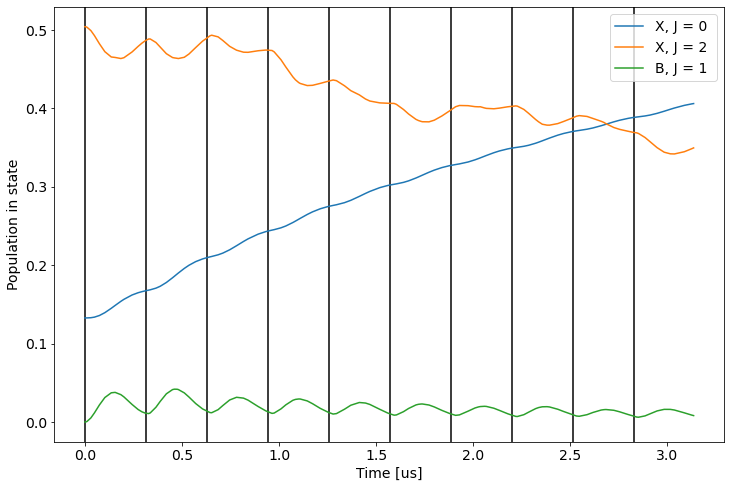

In [133]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("""sol.t""")


#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

print(P0[-1]/P0[0])

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)


m = t_array <= 5e6/(νp)/1e6

t_array = t_array[m]
pop_results = pop_results[:,m]
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1 ')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
for i in range(10):
    ax.axvline(i*1e6/νp/2, zorder = 0, color = 'k')

## Effect of tolerances

Varying the tolerances to see what effect it has on the runtime and the final result.

In [134]:
abstolerances = np.logspace(-6,-9,7)
reltolerances = np.logspace(-3,-6,7)

In [135]:
import time

elapsed_times = []
time_arrays = []
solutions = []
for abstol, reltol in tqdm(zip(abstolerances, reltolerances), total=len(abstolerances)):
    # compile function before timing
    dt = []
    Main.eval(f"""
    sol = solve(prob, Tsit5(), abstol = {abstol}, reltol = {reltol})
    tmp = 0
    """)
    Main.eval(f'println({abstol}, ", ",{reltol})')
    for _ in range(3):
        tstart = time.time()
        Main.eval(f"""
        @time sol = solve(prob, Tsit5(), abstol = {abstol}, reltol = {reltol})
        tmp = 0
        """)
        tstop = time.time()
        dt.append(tstop - tstart)
    elapsed_times.append(np.mean(dt))
    ut = np.array(Main.eval("sol[:]")).T
    pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
    solutions.append(pop_results)
    time_arrays.append(np.array(Main.eval("sol.t")))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:36<00:00, 30.93s/it]


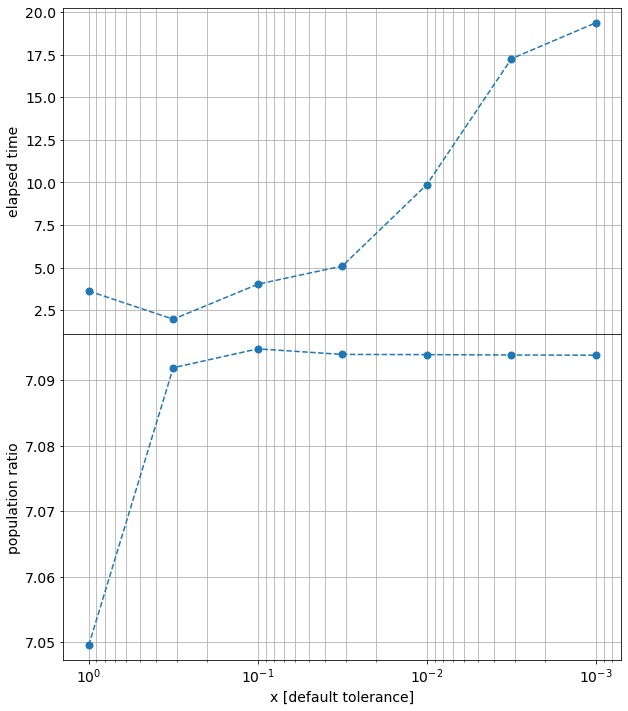

In [136]:
fig, axes = plt.subplots(2,figsize = (10,12), sharex = True, 
                         gridspec_kw = {'hspace': 0})

ax = axes[0]
ax.grid(True, which = 'both')

ax.plot(abstolerances*1e6, elapsed_times, '--.', ms = 14)

ax.set_xscale('log')
ax.set_ylabel('elapsed time', fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

ax = axes[1]
ax.grid(True, which = 'both')

factors = []
for sol, factor in zip(solutions, abstolerances*1e6):
    P0 = np.sum(sol[:4,:], axis = 0)
    factors.append(P0[-1]/P0[0])
    
ax.plot(abstolerances*1e6, factors, '--.', ms = 14, color = 'C0')

ax.set_xscale('log')
ax.invert_xaxis()
ax.set_xlabel('x [default tolerance]', fontsize = 14)
ax.set_ylabel('population ratio', fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

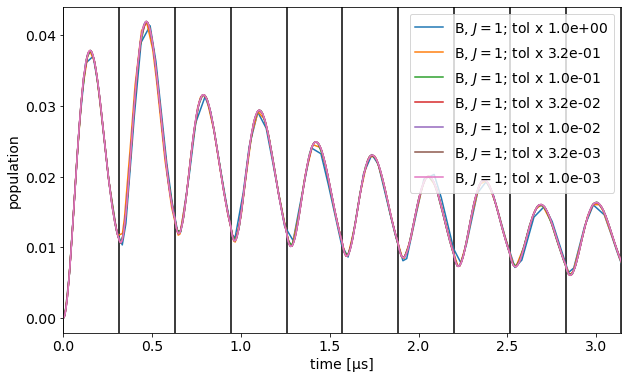

In [137]:
fig, ax = plt.subplots(figsize = (10,6))

for ti, sol, factor in zip(time_arrays, solutions, abstolerances*1e6):
    P0 = np.sum(sol[:4,:], axis = 0)
    P1 = np.sum(sol[4:16,:], axis = 0)
    P2 = np.sum(sol[16:36,:], axis = 0)
    PB1 = np.sum(sol[36:,:], axis = 0)
    
    ax.plot(ti*1e6, PB1, label = f'B, $J=1$; tol x {factor:.1e}')
    
ax.legend(fontsize = 14)
ax.set_xlabel('time [μs]', fontsize = 14)
ax.set_ylabel('population', fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

ax.set_xlim(0,5e6/νp)
for i in range(20):
    ax.axvline(i*1e6/νp/2, zorder = 0, color = 'k')

### Comparison with Python solution

Check the timing differences. Remember that the first run compiles the Julia code, and subsequent runs (even when changing parameters or initial conditions) are much faster.

In [138]:
%%time
sol = solve_ivp(Lindblad_rhs, t_span, ρ_vec, method = 'RK45', dense_output=False, 
                vectorized = False, args = [p], rtol = 2.5e-4, atol = 2.5e-7)

Wall time: 5.64 s


In [139]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 2.5e-7, reltol = 2.4e-4)
tmp = 0
""")

Wall time: 1.03 s


0

In [140]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 2.5e-7, reltol = 2.4e-4)
tmp = 0
""")

Wall time: 19.2 s


0

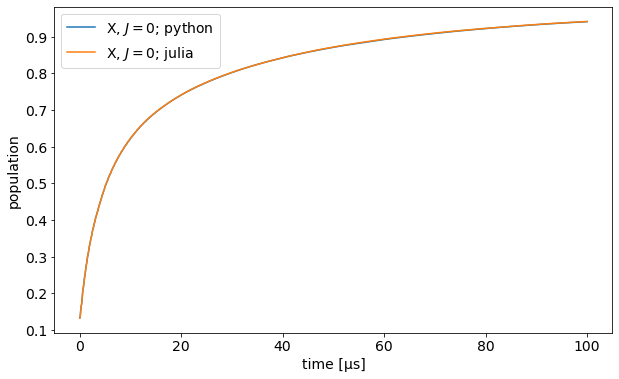

In [141]:
pop_results_scipy = np.real(np.einsum('jji->ji',sol.y.reshape((ρ_ini.shape[0], ρ_ini.shape[1], sol.y.shape[1]))))

_u = np.array(Main.eval("sol.u")).T
pop_results_julia = np.real(np.einsum('jji->ji',_u.reshape((ρ_ini.shape[0], ρ_ini.shape[1], _u.shape[2]))))

tmin = 0
tmax = 101e-6
m1 = (tmin < sol.t) & (sol.t < tmax)
m2 = (tmin < Main.eval('sol.t')) & (Main.eval('sol.t') < tmax)

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(sol.t[m1]*1e6, np.sum(pop_results_scipy[:4], axis = 0)[m1], label = r'X, $J=0$; python')
ax.plot(Main.eval("sol.t")[m2]*1e6, np.sum(pop_results_julia[:4], axis = 0)[m2], label = r'X, $J=0$; julia')

ax.legend(fontsize = 14)
ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
set_fontsize(ax, 14)

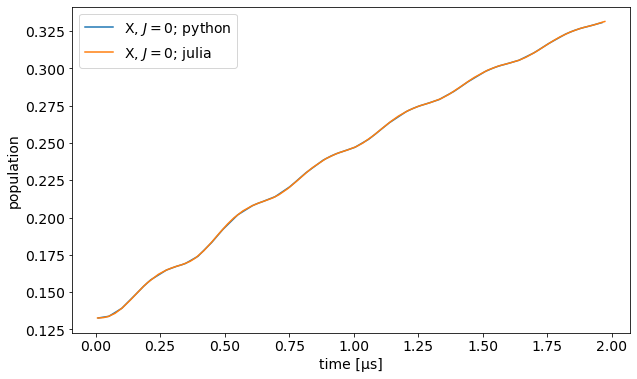

In [142]:
pop_results_scipy = np.real(np.einsum('jji->ji',sol.y.reshape((ρ_ini.shape[0], ρ_ini.shape[1], sol.y.shape[1]))))

_u = np.array(Main.eval("sol.u")).T
pop_results_julia = np.real(np.einsum('jji->ji',_u.reshape((ρ_ini.shape[0], ρ_ini.shape[1], _u.shape[2]))))

tmin = 0
tmax = 2e-6
m1 = (tmin < sol.t) & (sol.t < tmax)
m2 = (tmin < Main.eval('sol.t')) & (Main.eval('sol.t') < tmax)

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(sol.t[m1]*1e6, np.sum(pop_results_scipy[:4], axis = 0)[m1], label = r'X, $J=0$; python')
ax.plot(Main.eval("sol.t")[m2]*1e6, np.sum(pop_results_julia[:4], axis = 0)[m2], label = r'X, $J=0$; julia')

ax.legend(fontsize = 14)
ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
set_fontsize(ax, 14)

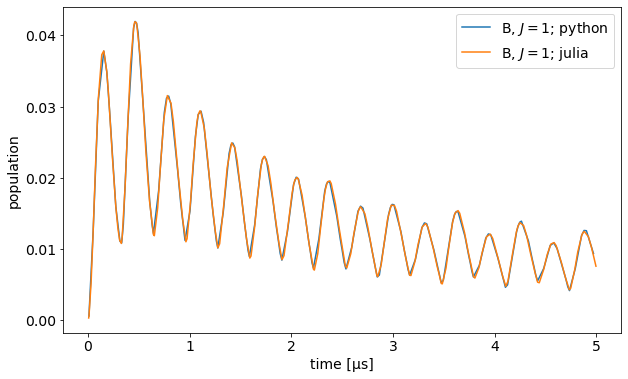

In [143]:
pop_results_scipy = np.real(np.einsum('jji->ji',sol.y.reshape((ρ_ini.shape[0], ρ_ini.shape[1], sol.y.shape[1]))))

_u = np.array(Main.eval("sol.u")).T
pop_results_julia = np.real(np.einsum('jji->ji',_u.reshape((ρ_ini.shape[0], ρ_ini.shape[1], _u.shape[2]))))

tmin = 0
tmax = 5e-6
m1 = (tmin < sol.t) & (sol.t < tmax)
m2 = (tmin < Main.eval('sol.t')) & (Main.eval('sol.t') < tmax)

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(sol.t[m1]*1e6, np.sum(pop_results_scipy[-3:], axis = 0)[m1], label = r'B, $J=1$; python')
ax.plot(Main.eval("sol.t")[m2]*1e6, np.sum(pop_results_julia[-3:,:], axis = 0)[m2], label = r'B, $J=1$; julia')

ax.legend(fontsize = 14)
ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
set_fontsize(ax, 14)

# Now doing parameter sweeps
All of the Julia ODE solutions above were found with a single core. Because we want to solve the ODE system for many different parameters we can leverage the multiple cores current computers have, or even run it on a cluster.

When using the ensemble simulations it is not advised to save all timestemps in memory, as this will quickly overwhelm the system RAM and cause swapping, greatly reducing computation speed. Luckily DifferentialEquations allows you to set which [timesteps to save](https://diffeq.sciml.ai/stable/basics/common_solver_opts/), and even to [reduce](https://diffeq.sciml.ai/stable/features/ensemble/#ensemble) the solution to a smaller form. E.g. for the optical bloch simulations you might only be interested in the diagonal matrix elements at the desired timestep; and the reduction allows you to only save those; resulting in a factor N reduction in memory usage for an NxN matrix. 

The simulation below requires at least a few GB RAM to run fully in memory. Reducing the tolerances will limit the memory usage somewhat.

First I'll demonstrate a sweep over Ω

In [118]:
Main.eval("Omegas = (Ω/4.5)*(0.25:0.25:4.25)")

[986116.5345569444,
 1972233.0691138888,
 2958349.603670833,
 3944466.1382277776,
 4930582.6727847215,
 5916699.207341666,
 6902815.741898611,
 7888932.276455555,
 8875048.811012499,
 9861165.345569443,
 10847281.880126389,
 11833398.414683333,
 12819514.949240277,
 13805631.483797222,
 14791748.018354166,
 15777864.55291111,
 16763981.087468054]

function to remake the problem for each iteration. Here the parameter `p`, the arguments for the ODE function, is modified for each run via a variable `i`.

In [119]:
Main.eval("""
function prob_func(prob,i,repeat)
    remake(prob,p=[Omegas[i],νp, Δ])
end
""")

<PyCall.jlwrap prob_func>

defining an ensemble problem, which takes the original ODEProblem as input and a function which changes the ODEProblem for each iteration

In [120]:
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

Again the first run will include the compilation time, however the more iterations you simulate the less this will matter.  

Some the main changes to the required inputs for the solver (see also [here](https://diffeq.sciml.ai/stable/features/ensemble/#ensemble)) are the ensemble solver method, in this case `EnsembleThreads()`, which is a Julia parallel method with shared memory. You need to make sure you have enough threads enabled though, since the default setting is 1. This is done by setting the environment variable `JULIA_NUM_THREADS=n`, where n is the number of cores you have in your pc. This has to be done before starting Julia. The number of threads can be checked with `Main.eval("Threads.nthreads()")`, as shown below.

In [121]:
Main.eval("Threads.nthreads()")

10

In [122]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(); trajectories= 17, abstol = 2.5e-7, reltol = 2.5e-4)
tmp = 0
sim.elapsedTime
""")

8.9331677

Runs in 21.8 seconds.  

Runtime without compilation:

In [123]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(); trajectories= 17, abstol = 2.5e-7, reltol = 2.5e-4)
tmp = 0
sim.elapsedTime
""")

3.246888101

Finished in 2.8 seconds. A single trajectory in python takes about 1.7 seconds.

In [124]:
ens_u = Main.eval("sim.u")

In [125]:
t_list = []
for i in range(len(ens_u)):
    t_list.append(Main.eval(f"sim.u[{i+1}].t"))

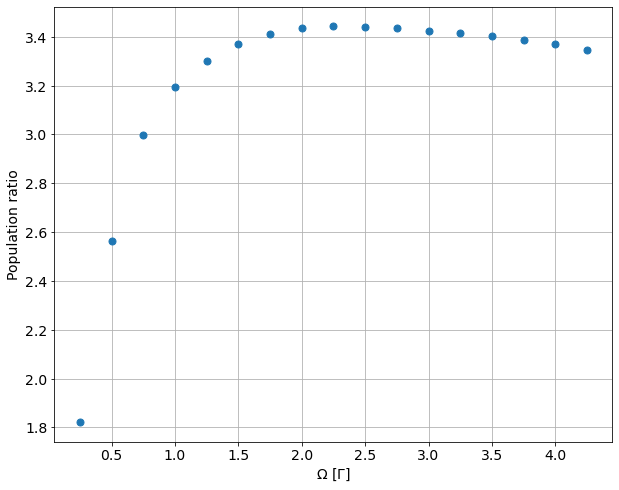

In [126]:
fig, ax = plt.subplots(figsize = (10,8))

for factor, t_array, ut_ens in zip(np.array(Main.Omegas)/(Ω/4.5), t_list,ens_u):
    ut_ens = np.array(ut_ens)
    t_array = np.array(t_array)
    pop_results = np.real(np.einsum('jji->ji',ut_ens.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut_ens.shape[2]))))
      
    P0 = np.sum(pop_results[:4], axis = 0)
    
    ax.plot(factor, P0[-1]/P0[0], '.', ms = 14, color = 'C0')
    
ax.set_xlabel(r"$\Omega$ [$\Gamma$]", fontsize = 14)
ax.set_ylabel("Population ratio", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

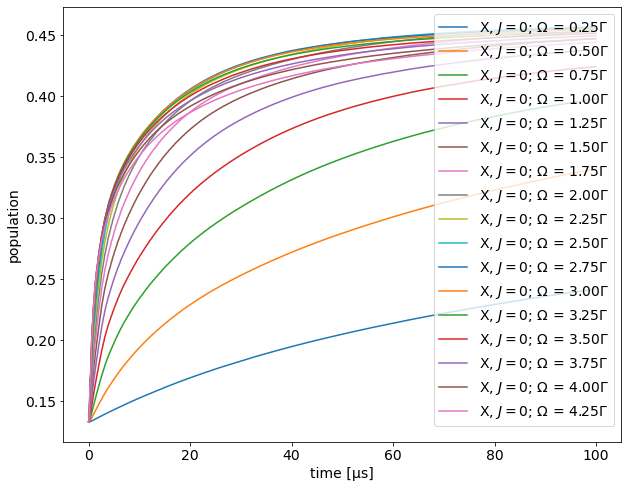

In [127]:
fig, ax = plt.subplots(figsize = (10,8))

for factor, t_array, ut_ens in zip(np.array(Main.Omegas)/(Ω/4.5), t_list,ens_u):
    ut_ens = np.array(ut_ens)
    t_array = np.array(t_array)
    pop_results = np.real(np.einsum('jji->ji',ut_ens.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut_ens.shape[2]))))
      
    P0 = np.sum(pop_results[:4], axis = 0)
    
    ax.plot(t_array*1e6, P0, ms = 14, label = f'X, $J=0$; Ω = {factor:.2f}Γ')

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
    
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

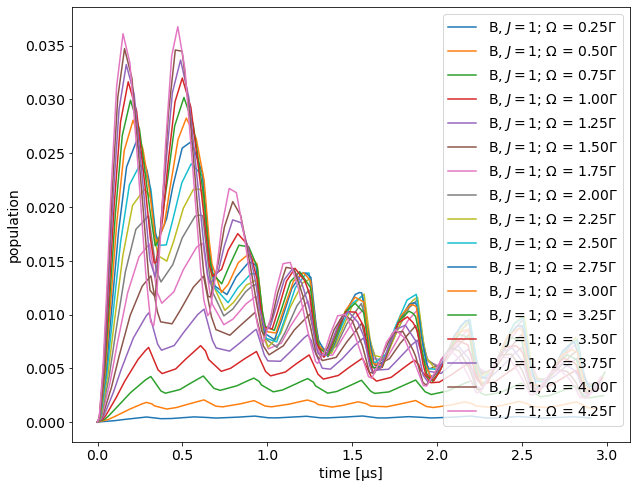

In [128]:
fig, ax = plt.subplots(figsize = (10,8))

for factor, t_array, ut_ens in zip(np.array(Main.Omegas)/(Ω/4.5), t_list,ens_u):
    ut_ens = np.array(ut_ens)
    t_array = np.array(t_array)
    pop_results = np.real(np.einsum('jji->ji',ut_ens.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut_ens.shape[2]))))
    
    m = t_array < 3e-6
    
    BP1 =  np.sum(pop_results[-3:,:], axis = 0)
    
    ax.plot(t_array[m]*1e6, BP1[m], ms = 14, label = f'B, $J=1$; Ω = {factor:.2f}Γ')

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
    
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

## Python Parameter Sweep

In [129]:
_p = p.copy()

In [130]:
%%time
for Omega in tqdm(Main.Omegas):
    sol = solve_ivp(Lindblad_rhs, t_span, ρ_vec, method = 'RK45', dense_output=False, 
                    vectorized = False, args = [[Omega, p[1]]], rtol = 2.5e-4, atol = 2.5e-7)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:25<00:00,  1.52s/it]

Wall time: 25.9 s
